# Statistical matching for each mine using multiple methods

In [2]:
#load packages
library(tidyverse)
library(MatchIt)
library(cem)
library(repr)
library(MetBrewer)
library(cowplot)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: tcltk

Warning message:
“no DISPLAY variable so Tk is not available”
Loading required package: lattice


How to use CEM? Type vignette("cem")




In [3]:
##set path to datasets
data_path = "PATH"

In [4]:
##read in the outcome dataset 
conf <- read_csv(paste(data_path, "/dfs/confounders.csv", sep=""))

Rows: 15695380 Columns: 27

── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (27): ID, year, pop_den, road_dist, x, y, province, agri_zone, mine_dist...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



 ## each mine matching PSM

In [ ]:
##read in list of mines and when the became active
ma <- read.csv(paste0(data_path,"dfs/mine_tyr.csv")) %>% arrange(mine)
mines <- ma$mine

In [ ]:
##read in the dataframe for each mine add to a lsit

mall = list()
for(i in 1:length(mines)) {
    mall[[i]] <- read.csv(paste(data_path,"/dfs/um_mines/",mines[i],".csv", sep="")) %>% 
                    mutate(mine = paste(mines[i]), pa_f = as.factor(round(pa)), 
                         agri_zone_f = as.factor(round(agri_zone)), province = as.factor(province + 1))
}

In [ ]:
##read in the dataframe for each mine add to a list - subsampled ones

m25 = list()
for(i in 1:length(mines)) {
    m25[[i]] <- read.csv(paste(data_path,"/dfs/um_mines_rs_25/",mines[i],".csv", sep="")) %>% 
                    mutate(mine = paste(mines[i]), pa_f = as.factor(round(pa)),  
                         agri_zone_f = as.factor(round(agri_zone)), province = as.factor(province + 1))
}

In [ ]:
##filter to just the province where most of the treated cells are
m2 = list()

for(i in 1:length(mines)) {
    m2[[i]] <- m25[[i]] %>% filter(province == names(which.max(table(mall[[i]][mall[[i]]$trt_con==1,]$province))))
    }

In [ ]:
##matching formula - used in a logistic regression
formula1 <- trt_con ~ tc_pre_yr + loss_2yr_bin + road_dist + elevation + slope + pop_den + burn_pre_2yr + pa_f  + agri_zone_f

In [ ]:
##loop through the mines and apply PSM matching -creates a list of matchIt objects and a list of dataframes of the matched data
x <- list()
d = list()
for(i in 1:length(mines)) {
    df <- m2[[i]]
    x[[i]] <-  matchit(formula = formula1, data = df, 
                       method = "nearest", discard="both", caliper = 0.25, exact = c('pa_f','agri_zone_f'))
    d[[i]] <- match.data(x[[i]],data = df,distance = "pscore") ##match data    
}

In [ ]:
##loop through matches and extract the quality info 
y = list()
sdm_df = data.frame() ##empty df for smd
nn_df = data.frame() ##empty df for smaple size

for(i in 1:length(mines)) {
     y[[i]] <- summary(x[[i]], standardize = TRUE) ##extract the summary 
    
    df = data.frame(covar = names(y[[i]]$sum.all[,3]), pre_m = unname(y[[i]]$sum.all[,3]), 
                        post_m = unname(y[[i]]$sum.matched[,3]), mine = mines[i]) ##get the smd data
    
    sdm_df <- rbind(df, sdm_df) 
    
    df2 <- data.frame(mine = mines[i], treat_pre_match = y[[i]]$nn[2,2], 
                        treat_post_match = y[[i]]$nn[4,2], con_post_match = y[[i]]$nn[4,1], con_pre_match = y[[i]]$nn[2,1],
                      percent_treat_matched = round((y[[i]]$nn[4,2]/y[[i]]$nn[2,2]) * 100)) # get the numbers matched data
    
     nn_df <- rbind(df2, nn_df)           
}

In [ ]:
## sort the smd data into a foramt for plotting
sdm_df <-  sdm_df %>% 
             pivot_longer(cols = starts_with('p'), names_to = 'match', values_to = 'smd') %>%
                mutate(covar = factor(covar, levels = rev(unique(covar))))

In [ ]:
##create pallete
pal2 <- as.list(met.brewer(name="Egypt", type="discrete"))

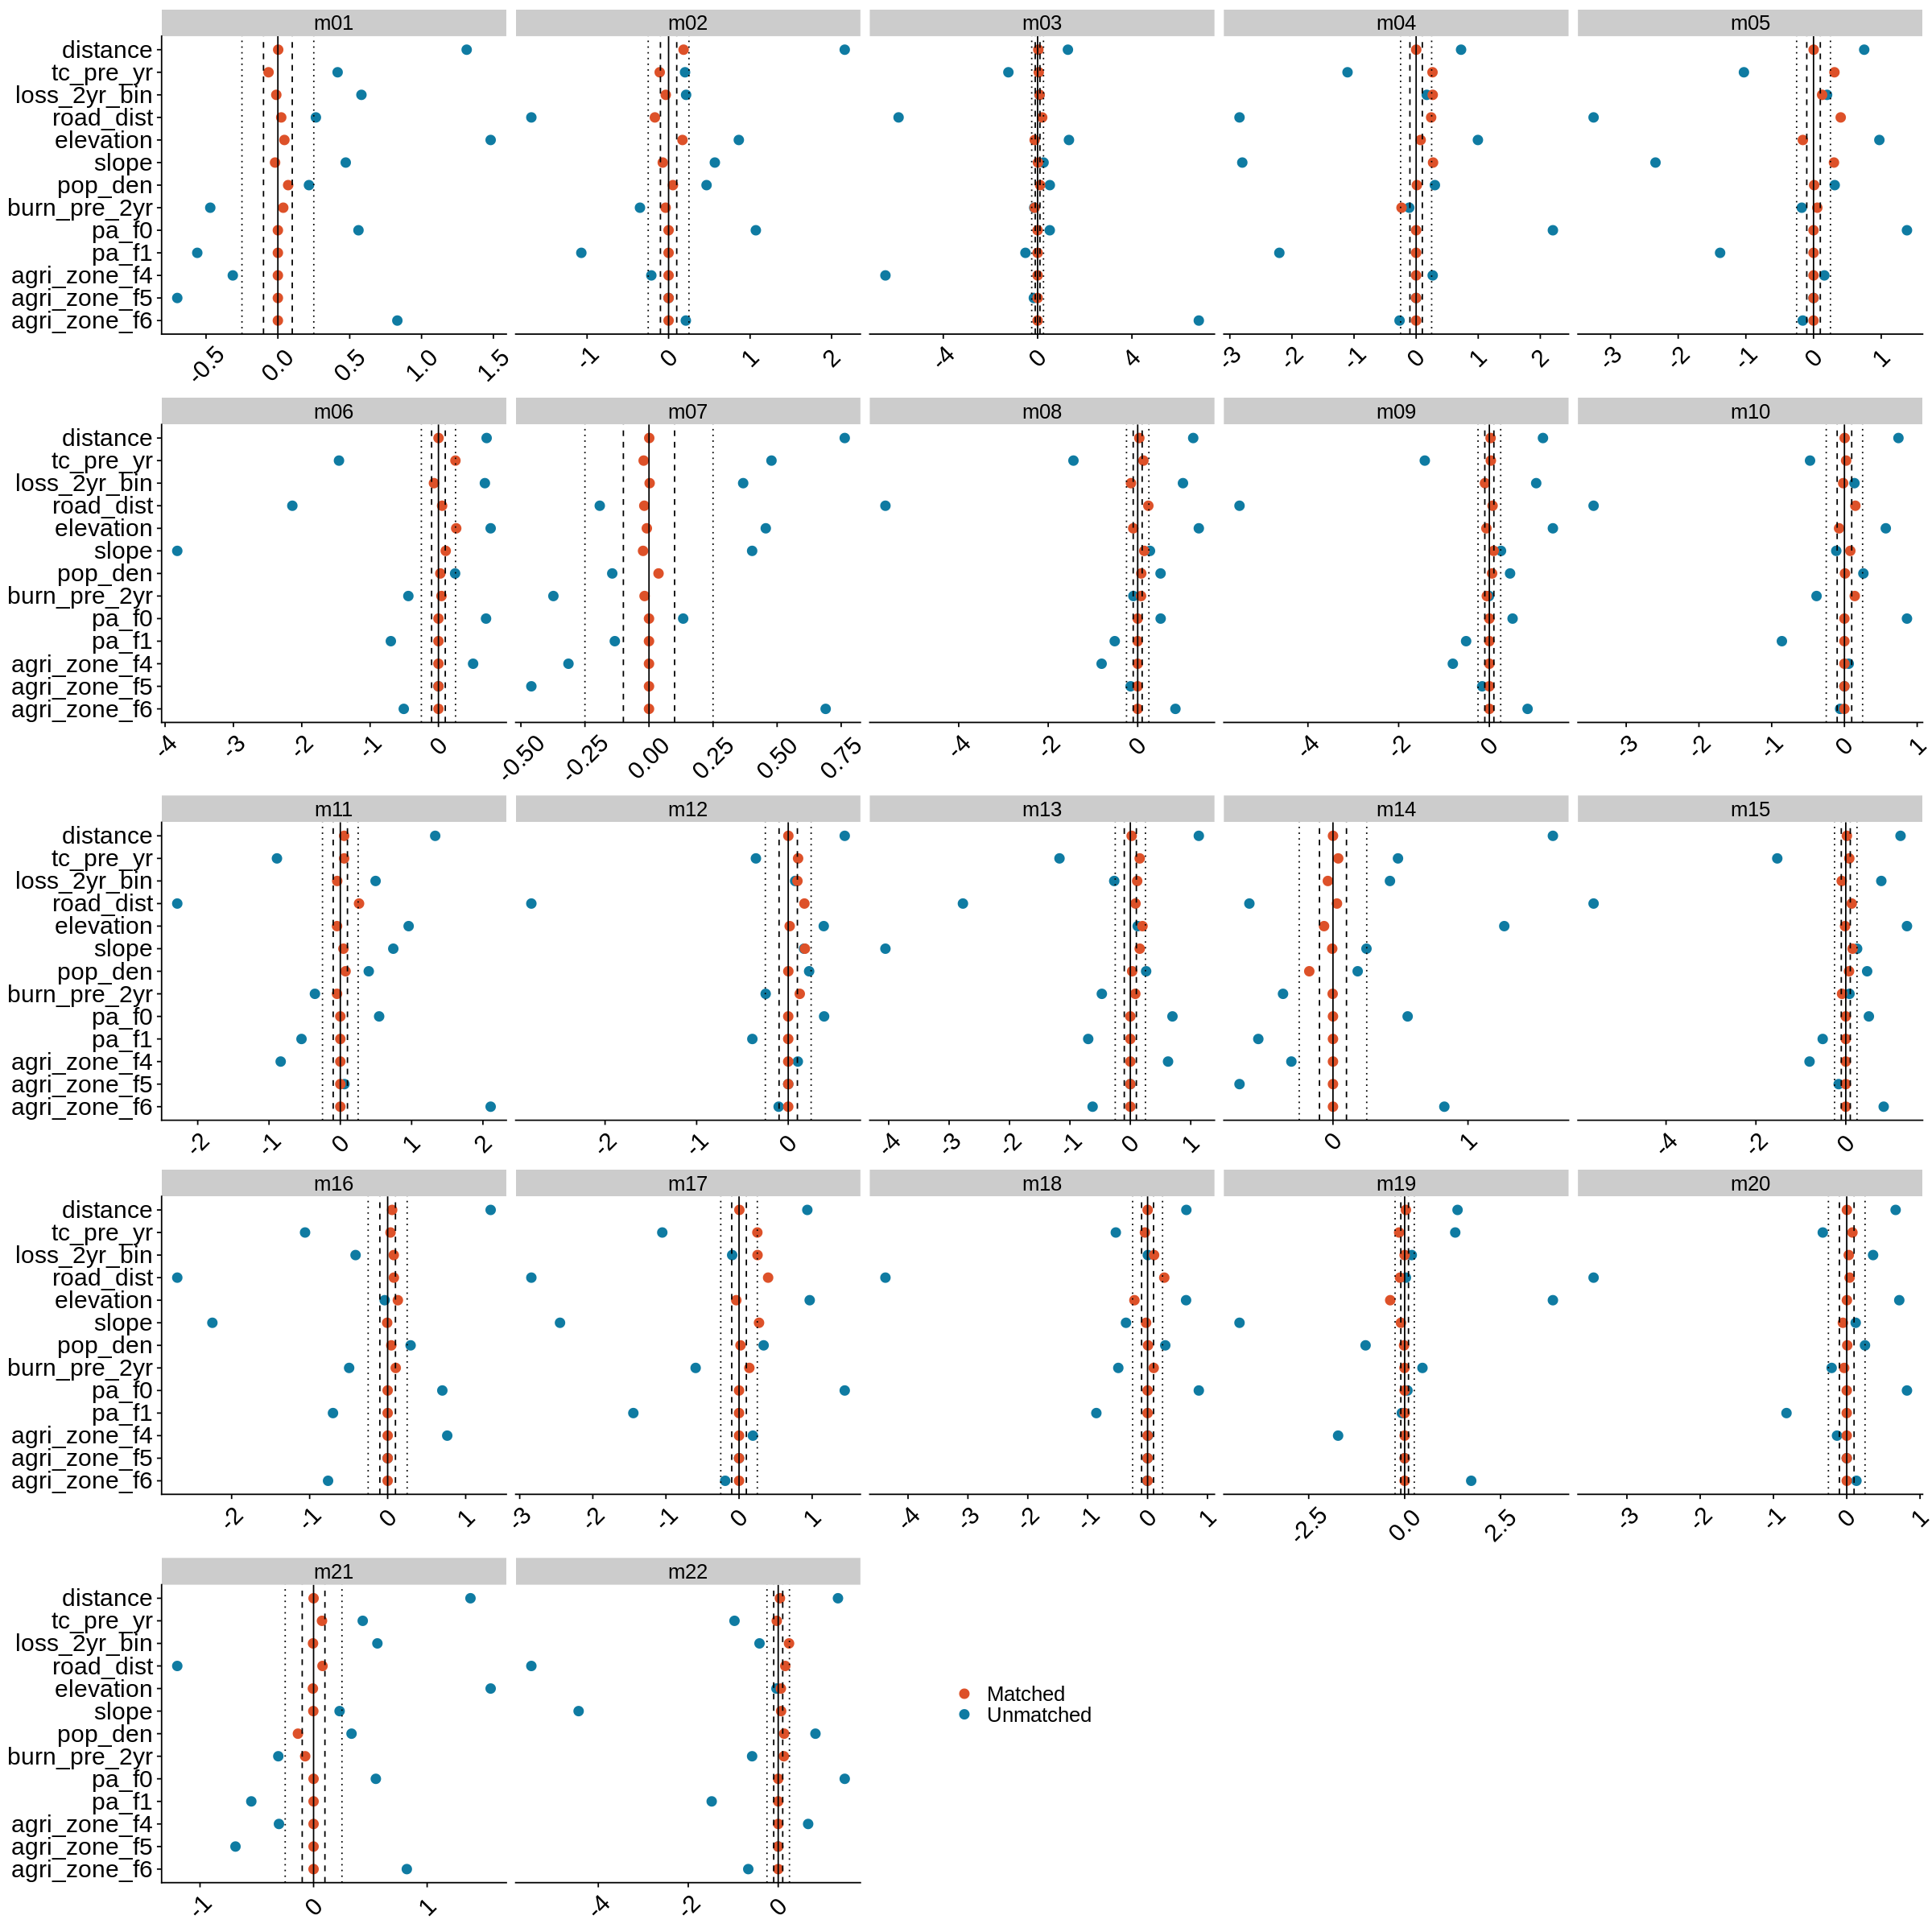

In [13]:
##produce plot of smds for all match years 
##plot ofthe smd for each confounder before and after the match, the 'distacne' measure is the propensity score
options(repr.plot.width=20, repr.plot.height=20)
(smd_plot <- ggplot(sdm_df) + 
geom_point(aes(covar, smd, colour = match), size = 3) +
facet_wrap(~mine, scales = "free_x", ncol = 5) +
geom_hline(yintercept = 0) + 
geom_hline(yintercept = -0.1, linetype = 'dashed') + geom_hline(yintercept = 0.1, linetype = 'dashed') +
geom_hline(yintercept = -0.25, linetype = 'dotted') + geom_hline(yintercept = 0.25, linetype = 'dotted') +
coord_flip() +
theme_cowplot() +
scale_colour_manual(values = pal2, labels = c('Matched', 'Unmatched')) +
theme(text = element_text(size = 18),  
         axis.title=element_blank(), 
         axis.text=element_text(size = 18),
         axis.text.x = element_text(angle = 45, vjust = 0.5), 
         legend.position = c(0.45,0.1), legend.title = element_blank())
)

In [ ]:
#ggsave(smd_plot, filename = 'figures/smd_psm.png', device = 'png', width = 16, height = 20.7)

In [17]:
### how many pixels have been syuccesffully matched percentage is for treatment only
nn_df

mine,treat_pre_match,treat_post_match,con_post_match,con_pre_match,percent_treat_matched
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m22,309,234,234,9460,76
m21,514,514,514,15979,100
m20,359,315,315,9460,88
m19,629,595,595,9460,95
m18,220,180,180,9460,82
m17,350,266,266,9460,76
m16,570,511,511,9460,90
m15,243,213,213,3345,88
m14,914,914,914,15979,100


In [ ]:
#write.csv(nn_df,'results/n_df_PSM.csv', row.names = F)

In [ ]:
##loop through mines and add the future years values for confoudners and outcome
p = list()
for (i in 1:length(mines)) {
    p[[i]] <- d[[i]][,c("ID",'trt_con',"mine")] %>% left_join(filter(conf, year >= ma$active[i]), by = "ID")
}

In [ ]:
##save the matched dataset in long form for each mine
for (i in 1:length(mines)) {
    write.csv(p[[i]], paste(data_path,"/dfs/psm_mines_rs_25/", mines[i], ".csv", sep=""), row.names = FALSE)
}

 ## each mine matching Coarsened Exact Matching

In [ ]:
##set the cut points for the coarsening of the data
treecut <-seq(10,60,10) ##tree cover in 10% bands up to 50
l2yr_cut = c(0,1) ##cells with previous forest loss
roadcut = c(5000,10000,20000)  
elevationcut = c(0,600,800,1000,1100,1200,1300,1400,1500) 
slopecut = c(0,5,12)
popcut = c(0,20,50,100)
burncut=c(0,1)

In [ ]:
##define the cut points for each varaible as a list
cuts <- list(tc_pre_yr=treecut, loss_2yr_bin = l2yr_cut , road_dist =roadcut, pop_den =popcut,
                     elevation =elevationcut, slope=slopecut, burn_pre_2yr = burncut)

In [ ]:
#set groups for the factors - matching exactly for each group
pa.grp = list("0","1")
ag.grp = list("4","5","6")
grouping = list(pa_f =pa.grp, agri_zone_f = ag.grp)

In [ ]:
##loop through mines and apply CEM matching - creates a list of matchIt objects
x2 <- list()
d2 = list()
for(i in 1:length(mines)) {
    df <- m2[[i]]
    x2[[i]] <-  matchit(formula = formula1, data = df, 
                        method = "cem", cutpoints = cuts, grouping = grouping)
    d2[[i]] <- match.data(x2[[i]],data = df,distance = "dist") ##match data    
}

In [ ]:
##loop through matches and extract the quality info 
y2 = list()

sdm_df2 = data.frame() 
nn_df2 = data.frame() 

for(i in 1:length(mines)) {
     y2[[i]] <- summary(x2[[i]], standardize = TRUE) 
    
    df = data.frame(covar = names(y2[[i]]$sum.all[,3]), pre_m = unname(y2[[i]]$sum.all[,3]), post_m = unname(y2[[i]]$sum.matched[,3]), mine = mines[i])
    sdm_df2 <-rbind(df, sdm_df2)
    
    df2 <- data.frame(mine = mines[i], treat_pre_match = y2[[i]]$nn[2,2], treat_post_match = y2[[i]]$nn[4,2], con_pre_match = y2[[i]]$nn[2,1],
                      con_post_match = y2[[i]]$nn[4,1], percent_treat = round(y2[[i]]$nn[4,2]/y2[[i]]$nn[2,2] *100))
    
    nn_df2 <- rbind(df2, nn_df2)            
}

In [ ]:
##sort smd data for plotting
sdm_df2 <-  sdm_df2 %>% 
             pivot_longer(cols = starts_with('p'), names_to = 'match', values_to = 'smd') %>%
                mutate(covar = factor(covar, levels = rev(unique(covar))))

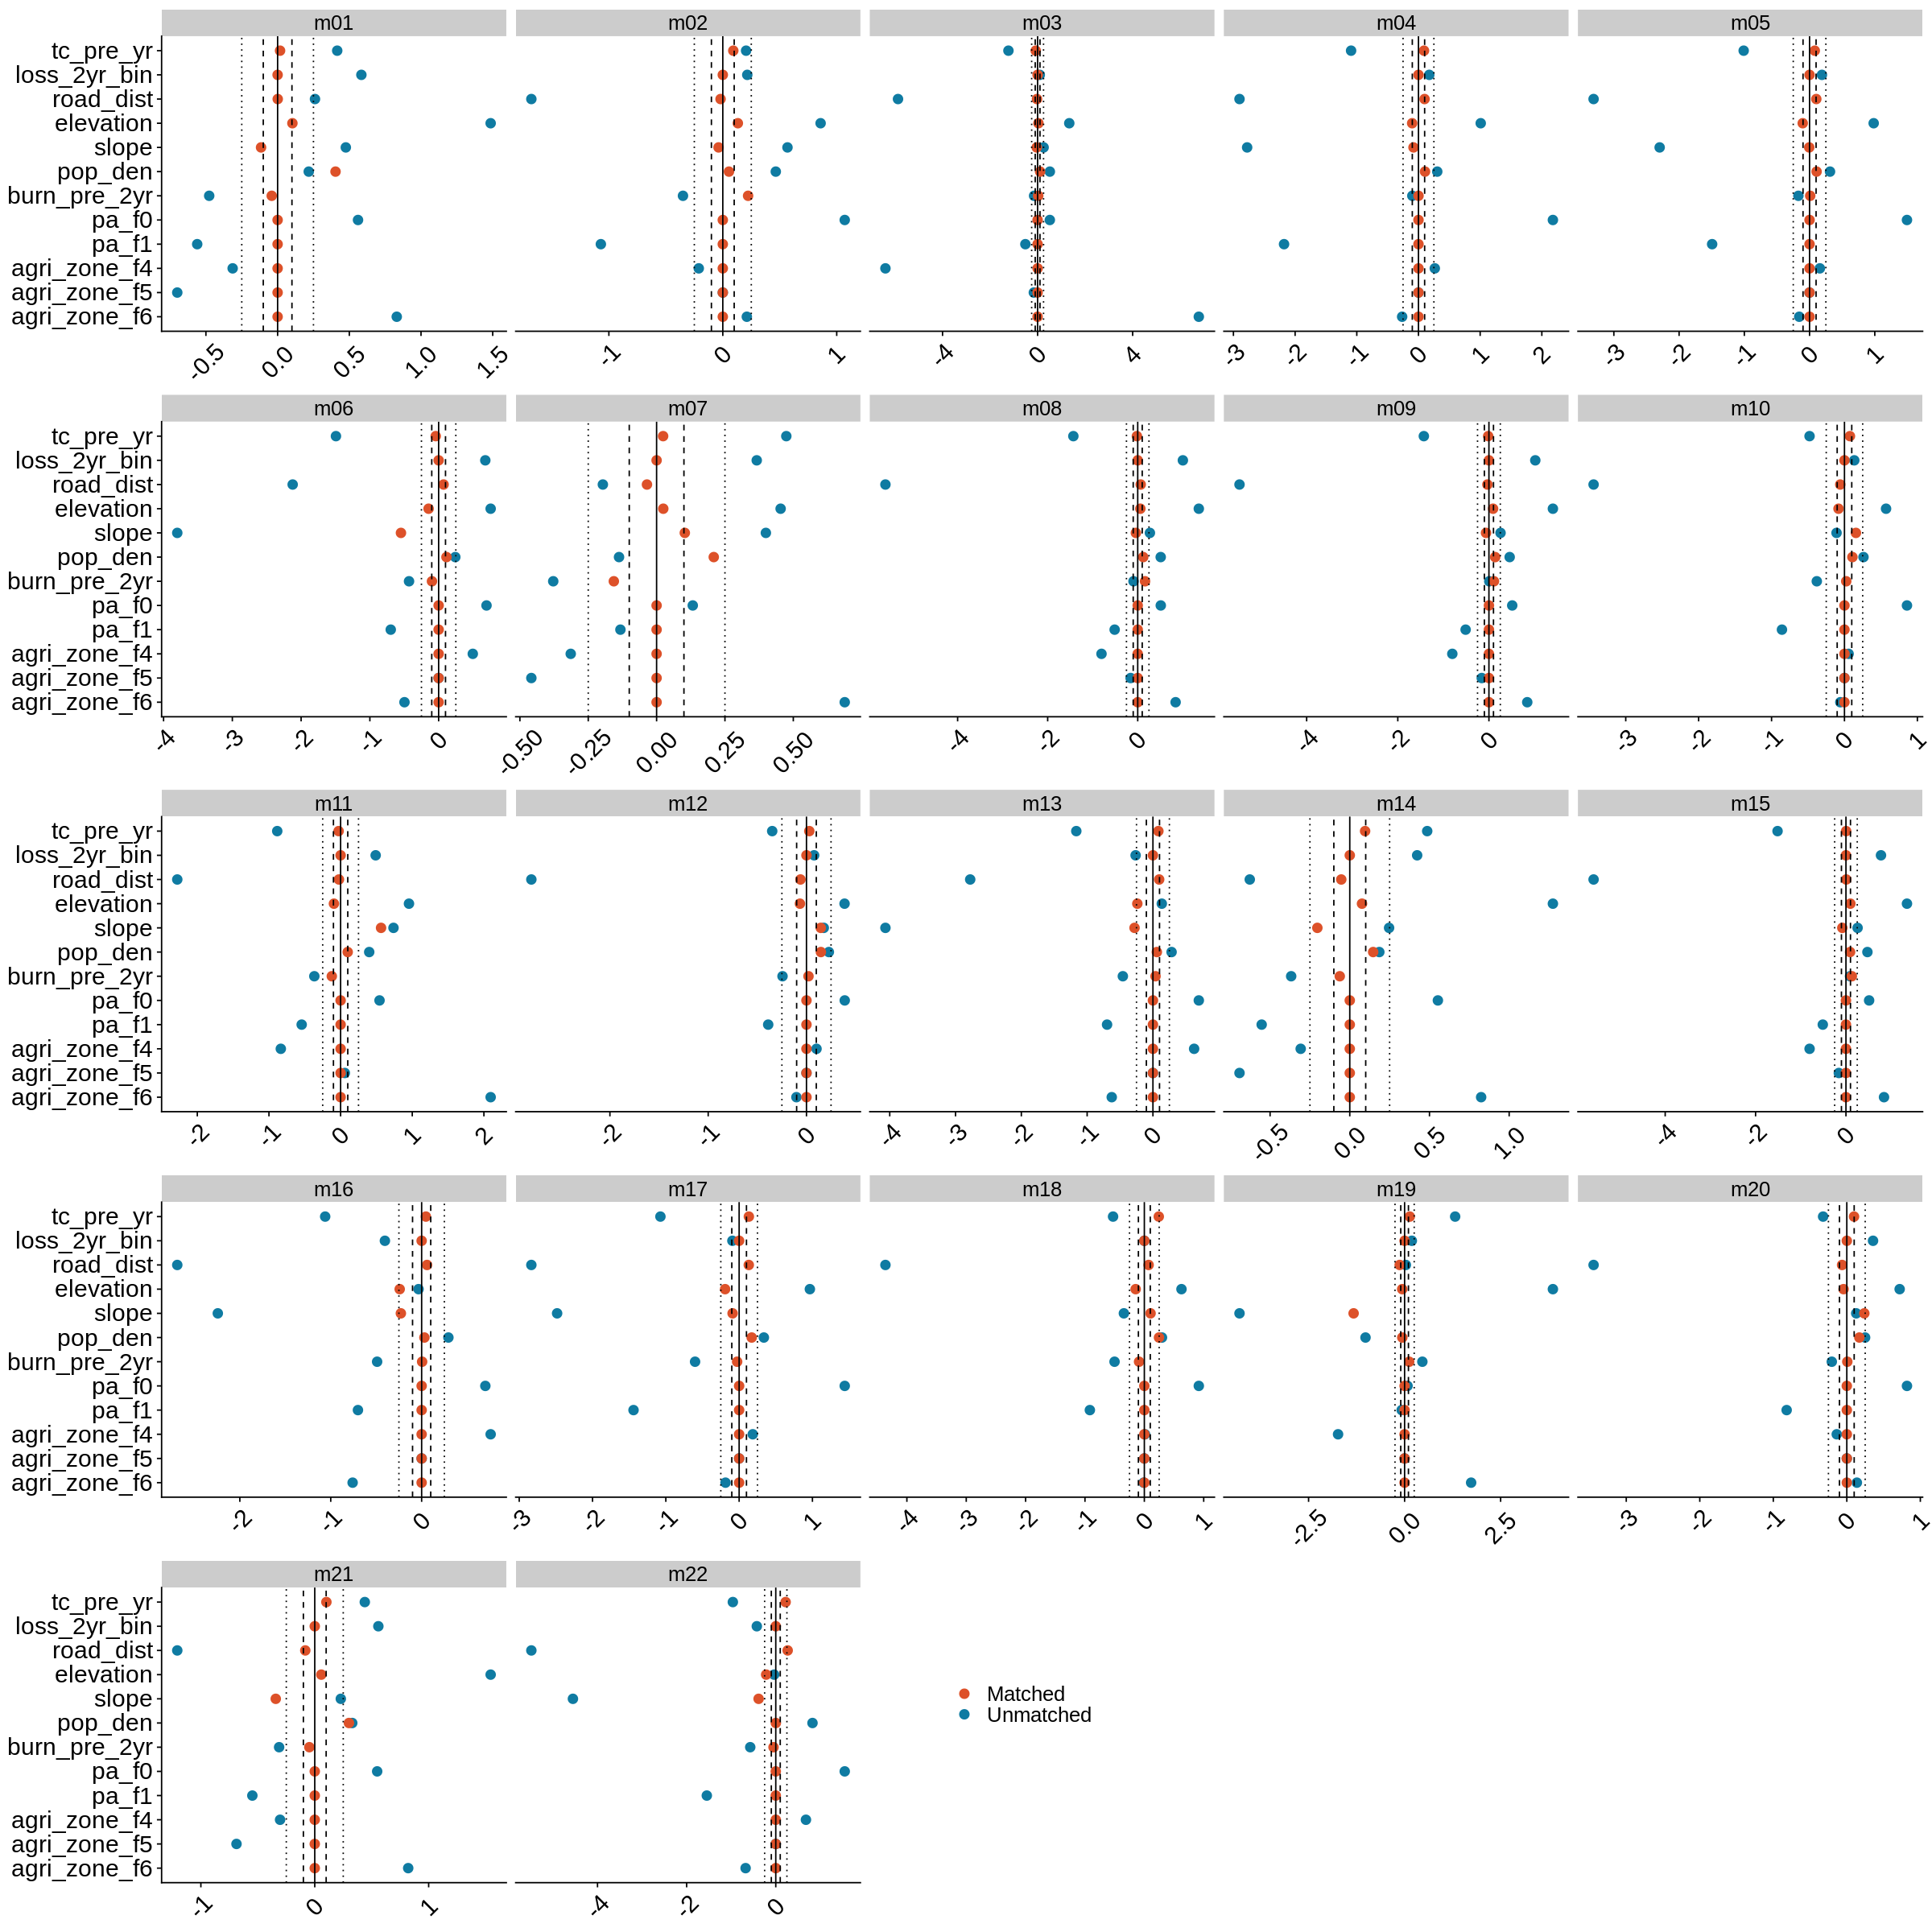

In [27]:
##produce plot of smds for all match years 
##plot of the smd for each confounder before and after the match

options(repr.plot.width=20, repr.plot.height=20)
(smd_plot <- ggplot(sdm_df2) + 
geom_point(aes(covar, smd, colour = match), size = 3) +
facet_wrap(~mine, scales = "free_x", ncol = 5) +
geom_hline(yintercept = 0) + 
geom_hline(yintercept = -0.1, linetype = 'dashed') + geom_hline(yintercept = 0.1, linetype = 'dashed') +
geom_hline(yintercept = -0.25, linetype = 'dotted') + geom_hline(yintercept = 0.25, linetype = 'dotted') +
coord_flip() +
theme_cowplot() +
scale_colour_manual(values = pal2, labels = c('Matched', 'Unmatched')) +
theme(text = element_text(size = 18),  
         axis.title=element_blank(), 
         axis.text=element_text(size = 18),
         axis.text.x = element_text(angle = 45, vjust = 0.5), 
         legend.position = c(0.45,0.1), legend.title = element_blank())
)

In [28]:
### how many pixels have been syuccesffully matched percentage is for treatment only
nn_df2

mine,treat_pre_match,treat_post_match,con_pre_match,con_post_match,percent_treat
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m22,309,229,9460,980,74
m21,514,509,15979,4086,99
m20,359,245,9460,2054,68
m19,629,493,9460,989,78
m18,220,136,9460,1174,62
m17,350,255,9460,1557,73
m16,570,446,9460,1640,78
m15,243,193,3345,436,79
m14,914,896,15979,4687,98


In [29]:
#write.csv(nn_df2,'results/n_df_CEM.csv', row.names = F)

In [ ]:
##loop through mines and add the future years values for confoudners and outcome
p2 = list()
for (i in 1:length(mines)) {
    p2[[i]] <- d2[[i]][,c("ID",'trt_con',"mine")] %>% 
                    left_join(filter(conf, year >= ma$active[i]), by = "ID")
}

In [ ]:
##save the matched dataset in long form for each mine
for (i in 1:length(mines)) {
    write.csv(p2[[i]], paste(data_path,"/dfs/cem_mines_rs_mix/", mines[i], ".csv", sep=""), row.names = FALSE)
}

 ## each mine matching PSM - with non_lel controls

In [ ]:
##read in the list of dataframe for each mine 
mall = list()
for(i in 1:length(mines)) {
    mall[[i]] <- read.csv(paste0(data_path,"/dfs/um_mines_nlel/",mines[i],".csv")) %>% 
                    mutate(mine = paste(mines[i]), pa_f = as.factor(round(pa)), 
                         agri_zone_f = as.factor(round(agri_zone)), province = as.factor(province + 1))
    }

In [ ]:
##read in the list of dataframe for each mine - subsampled version
m25 = list()
for(i in 1:length(mines)) {
    m25[[i]] <- read.csv(paste0(data_path,"/dfs/um_mines_nlel_rs_25/",mines[i],".csv")) %>% 
                    mutate(mine = paste(mines[i]), pa_f = as.factor(round(pa)), 
                         agri_zone_f = as.factor(round(agri_zone)), province = as.factor(province + 1))
}

In [ ]:
##filter to just the province where most of the treated cells are
m2 = list()

for(i in 1:length(mines)) {
    m2[[i]] <- m25[[i]] %>% filter(province == names(which.max(table(mall[[i]][mall[[i]]$trt_con==1,]$province))))
    }

In [ ]:
##forula for PSM matching
formula1 <- trt_con ~ tc_pre_yr + loss_2yr_bin + road_dist + elevation + slope + pop_den + burn_pre_2yr + pa_f  + agri_zone_f

In [ ]:
##loop through the mines and apply PSM matching
x <- list()
d = list()
for(i in 1:length(mines)) {
    df <- m2[[i]]
    x[[i]] <-  matchit(formula = formula1, data = df, 
                       method = "nearest", discard="both", caliper = 0.25, exact = c('pa_f','agri_zone_f'))
    d[[i]] <- match.data(x[[i]],data = df,distance = "pscore") ##match data    
}

In [ ]:
##loop through matches and extract the quality info 
y = list()
sdm_df = data.frame() 
nn_df = data.frame() 

for(i in 1:length(mines)) {
     y[[i]] <- summary(x[[i]], standardize = TRUE) 
    
    df = data.frame(covar = names(y[[i]]$sum.all[,3]), pre_m = unname(y[[i]]$sum.all[,3]), post_m = unname(y[[i]]$sum.matched[,3]), mine = mines[i])
   sdm_df <-rbind(df, sdm_df)
    
    df2 <- data.frame(mine = mines[i], treat_pre_match = y[[i]]$nn[2,2], treat_post_match = y[[i]]$nn[4,2], con_pre_match = y[[i]]$nn[2,1],
                      con_post_match = y[[i]]$nn[4,1], percent_treat = round(y[[i]]$nn[4,2]/y[[i]]$nn[2,2] *100))
    
     nn_df <- rbind(df2, nn_df)           
}

In [ ]:
##sort data for plotting
sdm_df <-  sdm_df %>% 
             pivot_longer(cols = starts_with('p'), names_to = 'match', values_to = 'smd') %>%
                mutate(covar = factor(covar, levels = rev(unique(covar))))

In [ ]:
pal2 <- as.list(met.brewer(name="Egypt", type="discrete"))

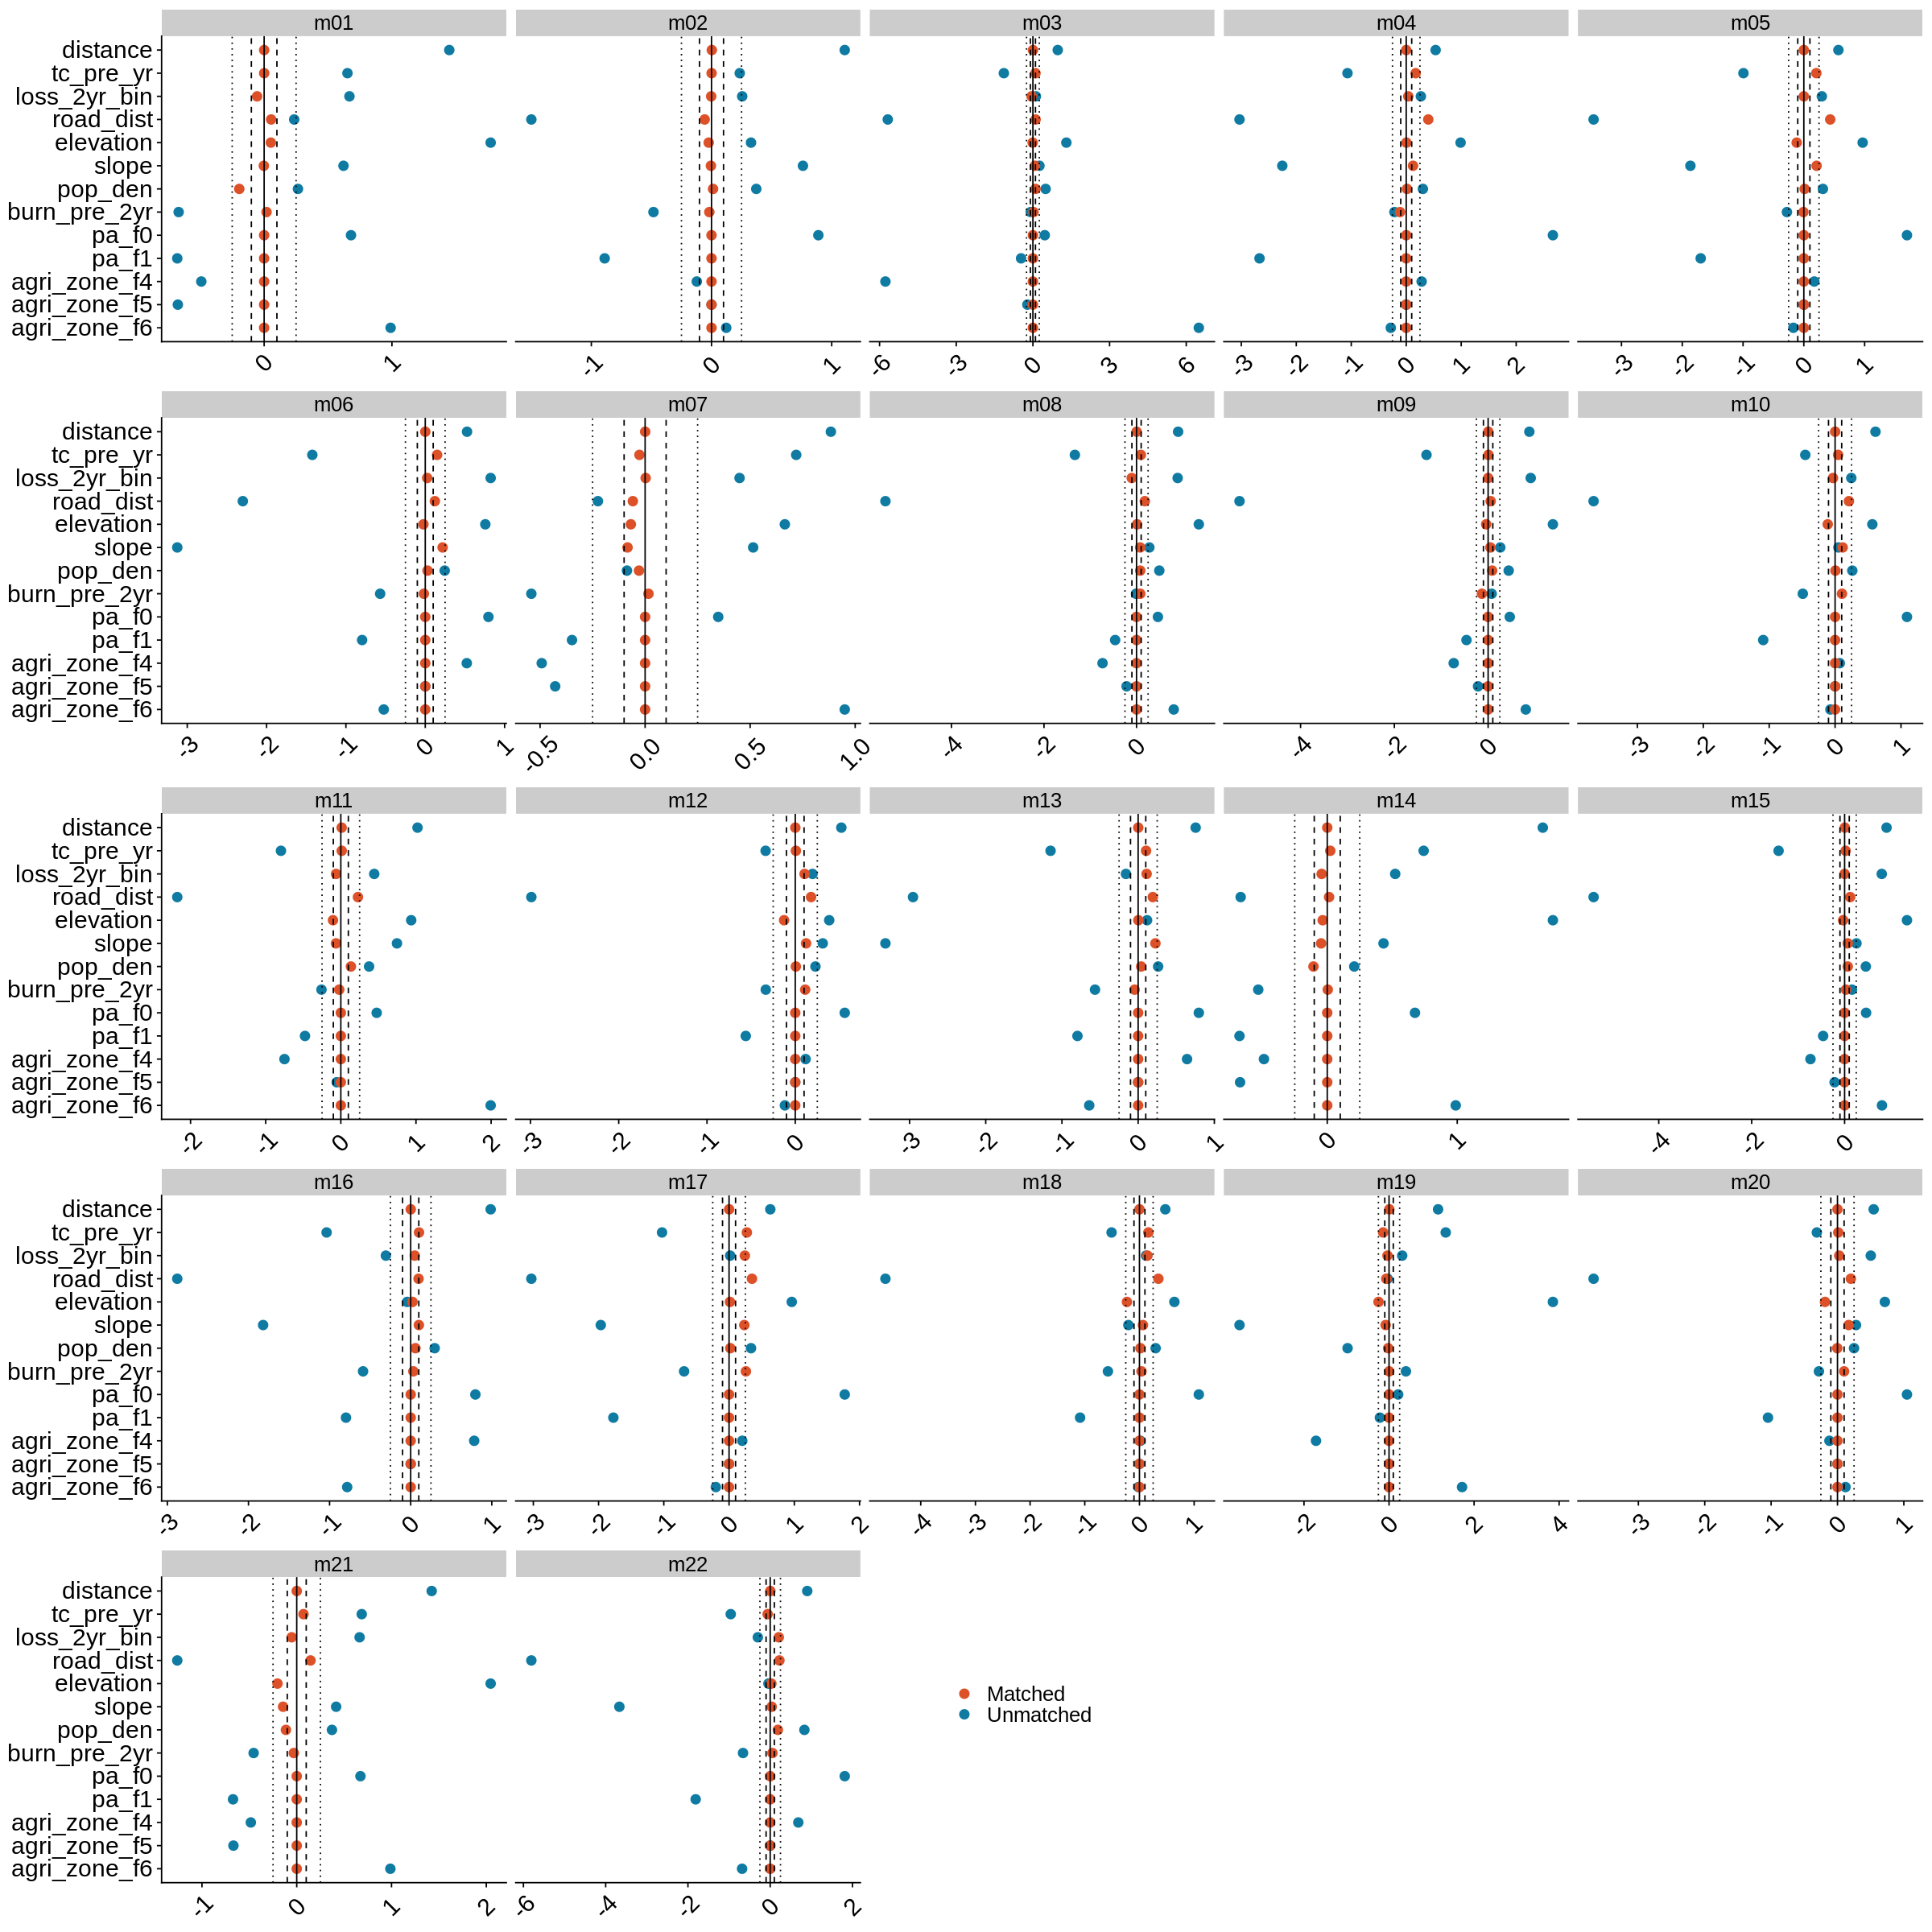

In [15]:
##produce plot of smds for all match years 

options(repr.plot.width=20, repr.plot.height=20)
(smd_plot <- ggplot(sdm_df) + 
geom_point(aes(covar, smd, colour = match), size = 3) +
facet_wrap(~mine, scales = "free_x", ncol = 5) +
geom_hline(yintercept = 0) + 
geom_hline(yintercept = -0.1, linetype = 'dashed') + geom_hline(yintercept = 0.1, linetype = 'dashed') +
geom_hline(yintercept = -0.25, linetype = 'dotted') + geom_hline(yintercept = 0.25, linetype = 'dotted') +
coord_flip() +
theme_cowplot() +
scale_colour_manual(values = pal2, labels = c('Matched', 'Unmatched')) +
theme(text = element_text(size = 18),  
         axis.title=element_blank(), 
         axis.text=element_text(size = 18),
         axis.text.x = element_text(angle = 45, vjust = 0.5), 
         legend.position = c(0.45,0.1), legend.title = element_blank())
)

In [16]:
### how many pixels have been syuccesffully matched percentage is for treatment only
nn_df

mine,treat_pre_match,treat_post_match,con_pre_match,con_post_match,percent_treat
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m22,313,293,21064,293,94
m21,522,522,26561,522,100
m20,361,328,21064,328,91
m19,630,621,21064,621,99
m18,225,196,21064,196,87
m17,352,289,21064,289,82
m16,574,560,21064,560,98
m15,249,238,6743,238,96
m14,921,921,26561,921,100


In [ ]:
#write.csv(nn_df,'results/n_df_nlel.csv', row.names = F)

In [ ]:
##loop through mines and add the future years values for confoudners and outcome
p = list()
for (i in 1:length(mines)) {
    p[[i]] <- d[[i]][,c("ID",'trt_con',"mine")] %>% 
                left_join(filter(conf, year >= ma$active[i]), by = "ID")
}

In [ ]:
##save the matched dataset in long form for each mine
for (i in 1:length(mines)) {
    write.csv(p[[i]], paste(data_path,"/dfs/psm_mines_nlel_rs_mix/", mines[i], ".csv", sep=""), row.names = FALSE)
}

## Unmatached dataset equal to just a random selection of non-lel controls the same length as treated 

In [ ]:
um = list()

for(i in 1:length(m2)){
    df = m2[[i]]
    trt = filter(df, trt_con == 1)
    cons = filter(df, trt_con == 0) %>%
            sample_n(nrow(trt)) # sample a random selection of the same nubmer of treatments as controls
    um[[i]] = bind_rows(trt, cons)
}

In [ ]:
##loop through mines and add the future years values for confoudners and outcome
p = list()
for (i in 1:length(mines)) {
    p[[i]] <- um[[i]][,c("ID",'trt_con',"mine")] %>% left_join(filter(conf, year >= ma$active[i]), by = "ID")
}

In [ ]:
##save the matched dataset in long form for each mine
for (i in 1:length(mines)) {
    write.csv(p[[i]], paste(data_path,"/dfs/rand_mines_rs_mix/", mines[i], ".csv", sep=""), row.names = FALSE)
}